This code is based on https://github.com/kimiandj/gsw

In [70]:
import sys
path_to_gsw='./gsw/'
sys.path.append(path_to_gsw)

import numpy as np
from gsw.gsw import GSW

from gsw_utils import load_data
from gsw_utils import w2,upperW2_smooth,get_minSW_smooth

import torch
from torch import nn
from torch.nn import functional as F
from torch.autograd import Function
from torch.nn.parameter import Parameter
from torch import optim

import ot
import pandas as pd
from tqdm import tqdm
from IPython import display
import time
import timeit

import pickle 
import matplotlib.pyplot as plt
import random
import os
torch.CUDA_VISIBLE_DEVICES=""

### We choose a dataset and load it
### The dataset name must be 'gaussian_2d', 'gaussian_500d', 'swiss_roll', 'half_moons', 'circle', '8gaussians' or '25gaussians'

In [71]:
dataset_name = '25gaussians'

In [72]:
N = 100  # Number of samples from p_X
X = load_data(name=dataset_name, n_samples=N,dim=4)
X -= X.mean(dim=0)[np.newaxis,:]  # Normalization
#X-=torch.tensor([5,5])
meanX = 0

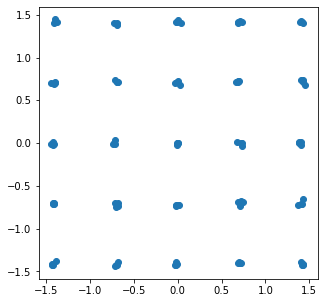

In [73]:
# Show the dataset
_, d = X.shape
fig = plt.figure(figsize=(5,5))
plt.scatter(X[:,0], X[:,1])
plt.show()

### We create the different folders to store the results

In [74]:
results_folder = './saved_results_GSW_flows'
if not os.path.isdir(results_folder):
    os.mkdir(results_folder)
foldername = os.path.join(results_folder, 'Gifs')
if not os.path.isdir(foldername):
    os.mkdir(foldername)
    
foldername = os.path.join(results_folder, 'Gifs', dataset_name + '_Comparison')
if not os.path.isdir(foldername):
    os.mkdir(foldername)

### We solve the two optimization problems for different defining functions and plot the results at each step

In [75]:
# Use GPU if available, CPU otherwise
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

device=torch.device('cpu')
torch.CUDA_LAUNCH_BLOCKING=1
print(device)

cpu


### experimental parameters
#### n =100 points
- gaussian 2d (100 points) : lr = 1e-2, 500 projections, max-sw: lr = 1e-2, 200 iterations, swgg: lr = 1e-2, 200 iters, s=10, std = 0.5
- gaussian 2d (1000 points) : idem
- gaussian 200d (100 points) : 
- 8 gaussians : lr = 1e-2, 500 projections, max-sw: lr = 1e-2, 200 iterations, swgg: lr = 1e-2, 200 iters, s=10, std=0.1
- two moons: lr = 
a marche une fois avec 50 points et l,theta[k],loss_min=gsw_res[k].get_minSW_smooth(X.to(device),Y[k].to(device),lr=1e-2,num_iter=400,s=50,std=0.1, init=theta_optim) + global lr = 2e-3
- swiss roll, lr=1e-2,num_iter=400,s=10,std=0.5, pas d'init pour theta optim
            
            


In [76]:
import importlib
import gsw
importlib.reload(gsw)

# Number of iterations for the optimization process
nofiterations = 5000

modes = ['linear', 'linear', 'linear','linear']
titles = ['SW', 'maxSW','SWGG Monte-Carlo','SWGG optim']

lear_rates=4*[3e-2]

degrees = [1,1,1,1]
n_proj = [1000,1,1000,1]


# Define the initial distribution
temp = np.random.normal(loc=meanX, scale=.25, size=(N,d))

# Define the variables to store the loss (2-Wasserstein distance) for each defining function and each problem
dist='w2'
w2_dist = np.nan * np.zeros((nofiterations, len(modes)))


# Define the optimizers
Y = list()
optimizer = list()
gsw_res = list()

for k in range(len(modes)):
    Y.append(torch.tensor(temp, dtype=torch.float, device=device, requires_grad=True))
    optimizer.append(optim.Adam([Y[k]], lr = lear_rates[k]))
    gsw_res.append(gsw.gsw.GSW(ftype=modes[k], degree=degrees[k], nofprojections=n_proj[k]))

KeyboardInterrupt: 

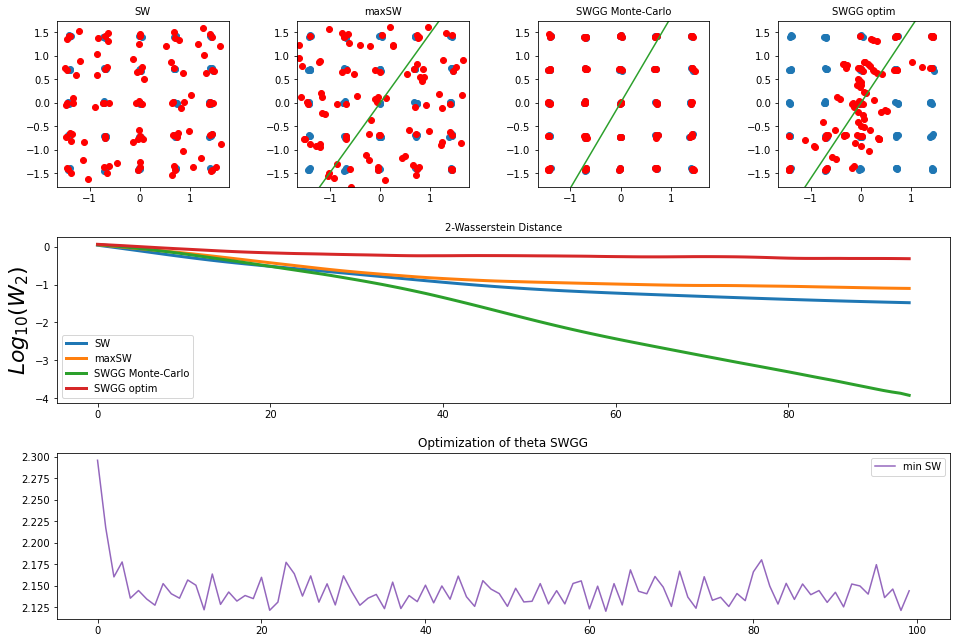

In [77]:
s=len(modes)

fig = plt.figure(figsize=(4*s, 8+3))
grid = plt.GridSpec(3, s, wspace=.4, hspace=0.3)

plot_fig = True

for i in range(nofiterations):
    print(i,end=' ')
    loss = list()
    theta = torch.ones(len(modes),d)
    # We loop over the different defining functions for the GSW problem
    
    for k in range(s):
        # Loss computation
        loss_ = 0
        if k==0:
            loss_ += gsw_res[k].gsw(X.to(device), Y[k].to(device),theta=None)
            
        if k==1:
            l,theta[k],loss_max=gsw_res[k].max_gsw(X.to(device),Y[k].to(device),500,1e-2)
            loss_ +=l 
            
        if k==2:
            l,theta[k] = gsw_res[k].minsw_negative(X.to(device), Y[k].to(device),theta=None)
            loss_+=l
            
        if k==3:
            l,theta[k],loss_min=gsw_res[k].get_minSW_smooth(X.to(device),Y[k].to(device),lr=2e0,num_iter=100,s=100,std=.5,init=theta[k])
            loss_ +=l
       
        # Optimization step
        loss.append(loss_)
        optimizer[k].zero_grad()
        loss[k].backward()
        optimizer[k].step()
        
        # Compute the 2-Wasserstein distance to compare the distributions
        if dist=='w2':
            w2_dist[i, k] = w2(X.detach().cpu().numpy(), Y[k].detach().cpu().numpy())
 
             
        theta=np.array(theta)   
        if plot_fig:
            if k==0:
                temp = Y[k].detach().cpu().numpy()
                plt.subplot(grid[k//s, k%s])
                plt.scatter(X[:,0], X[:,1])
                plt.scatter(temp[:,0], temp[:,1],c='r')
                plt.title(titles[k], fontsize=10)
                xlim1,xlim2=plt.xlim()
                ylim1,ylim2=plt.ylim()
            else :
                temp = Y[k].detach().cpu().numpy()
                plt.subplot(grid[k//s, k%s])
                plt.scatter(X[:,0], X[:,1])
                plt.scatter(temp[:,0], temp[:,1],c='r')
                plt.axline((0,0), theta[k][0:2], color='C2')
                plt.xlim(xlim1,xlim2)
                plt.ylim(ylim1,ylim2)
                plt.title(titles[k], fontsize=10)
    #print(theta[k])
    if plot_fig:
    # Plot the 2-Wasserstein distance
        plt.subplot(grid[1, 0:s])
        plt.plot(np.log10(w2_dist[:,:]), linewidth=3)
        plt.title('2-Wasserstein Distance', fontsize=10)
        plt.ylabel(r'$Log_{10}(W_2)$', fontsize=22)
        plt.legend(titles, fontsize=10, loc='lower left')
        
        plt.subplot(grid[2,:])
        plt.title('Optimization of theta SWGG')
        plt.plot(loss_min,c='C4',label='min SW')
        #plt.plot(loss_max,c='C0',label='max SW')
        plt.legend()
        
        
        display.clear_output(wait=True)
        display.display(plt.gcf()) 
        time.sleep(1e-5)

        # Save the figure 
        fig.savefig(foldername + '/img%03d.png'%(i))
        for k in range(s):
            plt.subplot(grid[:, k])
            plt.cla()
            
            

# Cross Validate s and std

In [64]:
p=1
X_cut=X[:,0:2].data
Y_cut=Y[0][:,0:2].data
num_proj=360*p
thetas = np.linspace(0, 2*np.pi, num_proj)
dire = np.array([(np.cos(theta),np.sin(theta)) for theta in thetas])
dir_torch=torch.from_numpy(dire).to(device)

msw_theta = [upperW2_smooth(X_cut,Y_cut,p.float(),s=1,std=0) for p in dir_torch]
msw_theta_pos = [upperW2_smooth(X_cut,Y_cut,p.float(),s=100,std=.5) for p in dir_torch]


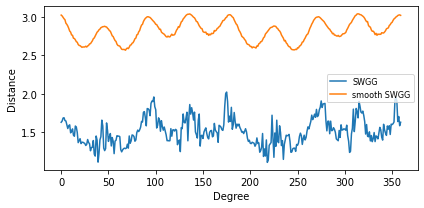

In [65]:
l=np.arange(0,360,1/p)
plt.figure(figsize=(6,3))
plt.plot(l,msw_theta, label="SWGG",c='C0')
plt.plot(l,msw_theta_pos, label="smooth SWGG",c='C1')
plt.xlabel('Degree')
plt.ylabel('Distance')
plt.tight_layout()
plt.legend(loc=5, prop={'size': 8})

/home/gui/Documents/Thèse/Approximation Wasserstein/Expe/Gradient Flow/./gsw/gsw_utils.py:57: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  theta=torch.tensor(init,device=X.device, dtype=X.dtype,requires_grad=True)
100%|██████████████████████████| 100/100 [00:00<00:00, 414.06it/s, loss = 2.640]


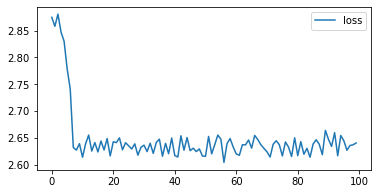

In [68]:
_,loss_l=get_minSW_smooth(X_cut,Y_cut,lr=2e0,num_iter=100,s=100,std=.5,init=torch.tensor([1,1]))
plt.figure(figsize=(6,3))
plt.plot(loss_l, label="loss",c='C0')
plt.legend()